# Proposta para OSS2025
![Segunda Arquitetura do Grupo](arc.png)

# Imports

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
from PIL import Image
import open_clip
import gc
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
import torch.nn as nn
from torch.nn import BatchNorm2d
from torch.nn import Dropout2d
from torch.nn import Sequential
from torch.nn import Linear
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
import torch.nn.functional as F
import cv2

import torchvision.transforms as transforms
from torchvision.io import read_video
import torchvision.io as tvio   
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchinfo import summary
from torch.utils.data import Dataset
from torchvision.io import read_video
from torchvision import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler


from livelossplot import PlotLosses

np.random.seed(0) 
torch.manual_seed(0)
import random
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
         for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

device = get_default_device()
print(device)

cpu


# Dataset

In [3]:
class MultiStreamVideoDataset(Dataset):
    def __init__(
        self,
        video_dir,             # directory with .mp4 videos
        label_path,            # path to .xls or .xlsx file
        clip_preprocess,       # from open_clip.create_model_and_transforms()
        num_2d_frames=8,
        num_3d_clips=4,
        frames_per_clip=16,
        prompt="a video of surgical skill",
        transform_3d=None,
        label_map=None         # optional dict to convert class names to ints
    ):
        self.video_dir = video_dir
        self.clip_preprocess = clip_preprocess
        self.num_2d_frames = num_2d_frames
        self.num_3d_clips = num_3d_clips
        self.frames_per_clip = frames_per_clip
        self.prompt = prompt
        self.transform_3d = transform_3d or transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ConvertImageDtype(torch.float32)
        ])
        self.labels_dict = self._load_labels(label_path)

        # List all video files that have a valid label
        self.videos = [
            f for f in os.listdir(video_dir)
            if f.endswith(".mp4") and os.path.splitext(f)[0] in self.labels_dict
        ]
        print(f"Found {len(self.videos)} videos with labels")

        if label_map:
            self.label_map = label_map
        else:
            unique_labels = sorted(set(self.labels_dict.values()))
            self.label_map = {name: i for i, name in enumerate(unique_labels)}
            
        # Print memory management info
        print(f"Using memory-efficient frame loading (not storing all frames)")

    def _load_labels(self, path):
        """Load labels from Excel file and map to video names"""
        if not os.path.exists(path):
            print(f"Warning: Label file not found: {path}")
            return {}

        try:
            df = pd.read_excel(path, header=0)

            required_columns = ["VIDEO", "GLOBA_RATING_SCORE"]
            for col in required_columns:
                if col not in df.columns:
                    print(f"Warning: Required column '{col}' not found in label file")
                    return {}

            drop_columns = ["STUDENT", "GROUP", "TIME", "SUTURES", "INVESTIGATOR"]
            cols_to_drop = [col for col in drop_columns if col in df.columns]
            df = df.drop(columns=cols_to_drop)

            df = df.groupby("VIDEO").mean()
            df["TARGET_CLASS"] = df["GLOBA_RATING_SCORE"].apply(
                lambda x: "novice" if 8 <= x < 16 else
                          "intermediate" if 16 <= x < 24 else
                          "proficient" if 24 <= x < 32 else
                          "expert" if 32 <= x <= 40 else "unknown"
            )

            return dict(zip(df.index, df["TARGET_CLASS"]))
        except Exception as e:
            print(f"Error processing label file {path}: {e}")
            return {}

    def __len__(self):
        return len(self.videos)

    def _sample_indices(self, total_frames, num_samples):
        if total_frames == 0:
            raise ValueError("Total frames is zero, cannot sample indices.")
        if total_frames < num_samples:
            return [i % total_frames for i in range(num_samples)]
        return sorted(random.sample(range(total_frames), num_samples))
    
    def _cv2_to_tensor(self, frame):
        """Convert an OpenCV frame to a PyTorch tensor safely"""
        # Convert BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # Convert to PIL Image for better compatibility with transforms
        pil_img = Image.fromarray(frame_rgb)
        return pil_img

    def __getitem__(self, idx):
        video_file = self.videos[idx]
        video_name = os.path.splitext(video_file)[0]
        label_str = self.labels_dict[video_name]
        label = self.label_map[label_str]

        video_path = os.path.join(self.video_dir, video_file)
        
        # Get total frames first
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError(f"Could not open video file: {video_path}")
            
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        # Sample 2D frame indices first
        idx_2d = self._sample_indices(total_frames, self.num_2d_frames)
        
        # Prepare for 3D clips
        clip_start_indices = []
        for _ in range(self.num_3d_clips):
            if total_frames < self.frames_per_clip:
                start_idx = 0
            else:
                start_idx = random.randint(0, total_frames - self.frames_per_clip)
            clip_start_indices.append(start_idx)
        
        # Get all needed frame indices
        clip_indices = []
        for start_idx in clip_start_indices:
            clip_indices.extend(range(start_idx, start_idx + self.frames_per_clip))
        
        # Combine all needed indices and sort them
        all_needed_indices = sorted(set(idx_2d + clip_indices))
        
        # Read only the needed frames
        frame_dict = {}
        current_frame = 0
        
        while True:
            ret, frame = cap.read()
            if not ret:
                break
                
            if current_frame in all_needed_indices:
                frame_dict[current_frame] = self._cv2_to_tensor(frame)
                
            current_frame += 1
            
            # Break early if we've read all needed frames
            if current_frame > max(all_needed_indices) and len(frame_dict) == len(all_needed_indices):
                break
                
        cap.release()
        
        # Process 2D frames
        try:
            frames_2d = [self.clip_preprocess(frame_dict[i]) for i in idx_2d]
            frames_2d = torch.stack(frames_2d)  # (T, C, H, W)
        except KeyError as e:
            missing_indices = [i for i in idx_2d if i not in frame_dict]
            print(f"Warning: Missing 2D frames at indices {missing_indices} for video {video_file}")
            # Use available frames or repeat the last frame
            available_indices = [i for i in idx_2d if i in frame_dict]
            if not available_indices:
                raise ValueError(f"No valid 2D frames found in video {video_file}")
            last_available = available_indices[-1]
            frames_2d = [self.clip_preprocess(frame_dict[i if i in frame_dict else last_available]) for i in idx_2d]
            frames_2d = torch.stack(frames_2d)

        # Process 3D clips
        clips_3d = []
        for start_idx in clip_start_indices:
            try:
                clip_indices = range(start_idx, start_idx + self.frames_per_clip)
                clip_frames = [frame_dict[i] if i in frame_dict else frame_dict[max(frame_dict.keys())] for i in clip_indices]
                
                # Apply 3D transform
                processed_frames = []
                for frame in clip_frames:
                    tensor_frame = transforms.ToTensor()(frame)  # Convert PIL to tensor
                    processed_frame = self.transform_3d(tensor_frame)
                    processed_frames.append(processed_frame)
                
                clip = torch.stack(processed_frames)  # (T, C, H, W)
                clip = clip.permute(1, 0, 2, 3)  # (C, T, H, W)
                clips_3d.append(clip)
            except Exception as e:
                print(f"Error processing 3D clip in video {video_file}: {e}")
                # Create a dummy clip with zeros if necessary
                if not clips_3d:
                    dummy_clip = torch.zeros(3, self.frames_per_clip, 256, 256)
                    print(f"Warning: Creating dummy clip for video {video_file}")
                    clips_3d.append(dummy_clip)

        clips_3d = torch.stack(clips_3d)  # (S, C, T, H, W)

        return frames_2d, clips_3d, self.prompt, label

# Dataloader

In [4]:
# Import your model and dataset classes
# Assuming you've already defined MultiStreamVideoDataset and MultiStreamVideoClassifier

def create_data_loaders(dataset, train_idx, val_idx, test_idx, batch_size=4):
    """Create data loaders for train, validation and test sets."""
    
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    
    train_loader = DataLoader(
        dataset, 
        batch_size=batch_size,
        sampler=train_sampler,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        dataset, 
        batch_size=batch_size,
        sampler=val_sampler,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        dataset, 
        batch_size=batch_size,
        sampler=test_sampler,
        pin_memory=True
    )
    
    return train_loader, val_loader, test_loader

# Optional: Set smaller batch sizes and frame counts to reduce memory usage
BATCH_SIZE = 2  # Try smaller batch size first
NUM_2D_FRAMES = 8  # Reduce from 8
NUM_3D_CLIPS = 4   # Reduce from 4
FRAMES_PER_CLIP = 16  # Reduce from 16

_, _, clip_preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained='laion2b_s34b_b79k')

dataset = MultiStreamVideoDataset(
    video_dir="Package_train",
    label_path="OSATS.xlsx",
    clip_preprocess=clip_preprocess,
    num_2d_frames=NUM_2D_FRAMES,  # Adjust based on memory constraints
    num_3d_clips=NUM_3D_CLIPS,   # Adjust based on memory constraints
    frames_per_clip=FRAMES_PER_CLIP, # Optimal for R3D models
    prompt="a video of suturing skill assessment",
    label_map={
        "novice": 0,
        "intermediate": 1,
        "proficient": 2,
        "expert": 3
    },
)

# Create train/val/test splits - 70%/20%/10%
indices = list(range(len(dataset)))
# Ideally, you would want to stratify based on the labels
# train_idx, temp_idx = train_test_split(indices, test_size=0.3, random_state=0, stratify=[dataset.labels_dict[os.path.splitext(dataset.videos[i])[0]] for i in indices])
# val_idx, test_idx = train_test_split(temp_idx, test_size=0.33, random_state=0, stratify=[dataset.labels_dict[os.path.splitext(dataset.videos[i])[0]] for i in temp_idx])

train_idx, temp_idx = train_test_split(indices, test_size=0.3, random_state=0)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.33, random_state=0)

print(f"Train: {len(train_idx)} samples, Validation: {len(val_idx)} samples, Test: {len(test_idx)} samples")

# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    dataset, train_idx, val_idx, test_idx, BATCH_SIZE
)

Found 12 videos with labels
Using memory-efficient frame loading (not storing all frames)
Train: 8 samples, Validation: 2 samples, Test: 2 samples


# Train

In [5]:
# Import metrics from the MICCAI24 package
from metrics4MICCAI24.expected_cost import get_expected_cost
from metrics4MICCAI24.utils import get_multi_class_confusion_matrix
from metrics4MICCAI24.utils import load_csv, get_multiclass_tp_tn_fp_fn


def get_f1(data_df, num_classes=4):
    """
    Calculate the F1 score for the given data.
    Args:
        data_df: dataframe with columns 'item_id', 'ground_truth', 'prediction'.
        num_classes: number of classes.

    Returns:
        float: The F1 score.
    """
    tp, tn, fp, fn, _ = get_multiclass_tp_tn_fp_fn(data_df, num_classes)
    f1_scores = []
    for i in range(num_classes):
        if tp[i] + fp[i] > 0 and tp[i] + fn[i] > 0 and tp[i] > 0:
            precision = tp[i] / (tp[i] + fp[i])
            recall = tp[i] / (tp[i] + fn[i])
            f1 = 2 * precision * recall / (precision + recall)
            f1_scores.append(f1)
        else:
            f1_scores.append(0)
    print(f1_scores)
    return sum(f1_scores) / len(f1_scores)

# Adapter functions to work with MICCAI24 metrics package
def _create_metrics_dataframe(labels, predictions):
    """
    Create a DataFrame in the format expected by MICCAI24 metrics.
    
    Args:
        labels: List or array of ground truth labels.
        predictions: List or array of predicted labels.
        
    Returns:
        pandas.DataFrame: DataFrame with columns 'item_id', 'ground_truth', 'prediction'.
    """
    # Create dummy item_ids
    item_ids = list(range(len(labels)))
    
    data = {
        'item_id': item_ids,
        'ground_truth': labels,
        'prediction': predictions
    }
    return pd.DataFrame(data)

def train_epoch(model, dataloader, criterion, optimizer, device, num_classes=4):
    """
    Train for one epoch
    """
    model.train()
    running_loss = 0.0
    all_predictions = []
    all_labels = []
    
    for frames_2d, clips_3d, prompts, labels in tqdm(dataloader, desc="Training"):
        # Move data to device
        frames_2d = frames_2d.to(device)
        clips_3d = clips_3d.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(frames_2d, clips_3d, prompts)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * frames_2d.size(0)
        _, preds = torch.max(outputs, 1)
        
        all_predictions.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader.dataset)
    
    # Create DataFrame for MICCAI24 metrics
    data_df = _create_metrics_dataframe(all_labels, all_predictions)
    
    # Use MICCAI24 metrics
    f1_score = get_f1(data_df, num_classes)
    expected_cost = get_expected_cost(data_df, num_classes)
    
    return epoch_loss, f1_score, expected_cost

def validate(model, dataloader, criterion, device, num_classes=4):
    """
    Validate the model
    """
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for frames_2d, clips_3d, prompts, labels in tqdm(dataloader, desc="Validation"):
            # Move data to device
            frames_2d = frames_2d.to(device)
            clips_3d = clips_3d.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(frames_2d, clips_3d, prompts)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * frames_2d.size(0)
            _, preds = torch.max(outputs, 1)
            
            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader.dataset)
    
    # Create DataFrame for MICCAI24 metrics
    data_df = _create_metrics_dataframe(all_labels, all_predictions)
    
    # Use MICCAI24 metrics
    f1_score = get_f1(data_df, num_classes)
    expected_cost = get_expected_cost(data_df, num_classes)
    
    return epoch_loss, f1_score, expected_cost

def test(model, dataloader, device, num_classes=4):
    """
    Test the model and return metrics
    """
    model.eval()
    all_predictions = []
    all_labels = []
    item_ids = []  # To track item IDs if available
    
    with torch.no_grad():
        batch_idx = 0
        for frames_2d, clips_3d, prompts, labels in tqdm(dataloader, desc="Testing"):
            # Move data to device
            frames_2d = frames_2d.to(device)
            clips_3d = clips_3d.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(frames_2d, clips_3d, prompts)
            _, preds = torch.max(outputs, 1)
            
            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Generate sequential item IDs if actual IDs aren't available
            batch_item_ids = list(range(batch_idx * frames_2d.size(0), 
                                        (batch_idx + 1) * frames_2d.size(0)))
            item_ids.extend(batch_item_ids)
            batch_idx += 1
    
    # Create DataFrame for MICCAI24 metrics
    data_df = _create_metrics_dataframe(all_labels, all_predictions)
    
    # Use MICCAI24 metrics
    f1_score = get_f1(data_df, num_classes)
    expected_cost = get_expected_cost(data_df, num_classes)
    
    return f1_score, expected_cost, all_predictions, all_labels, item_ids

def train_model(
    model, 
    train_loader, 
    val_loader, 
    test_loader,
    num_epochs=5, 
    lr=0.001, 
    weight_decay=1e-4,  # l2
    save_dir='checkpoints',
    num_classes=4 
):
    """
    Train the model
    """
    # Set up
    model = model.to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Learning rate scheduler
    #scheduler = scheduler.ReduceLROnPlateau(
    #   optimizer, mode='min', factor=0.5, patience=3, verbose=True
    #)
    
    # Ensure save directory exists
    os.makedirs(save_dir, exist_ok=True)
    
    # Initialize LiveLossPlot
    liveloss = PlotLosses()
    
    best_val_f1 = 0.0
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Train
        train_loss, train_f1, train_cost = train_epoch(
            model, train_loader, criterion, optimizer, device, num_classes
        )
        
        # Validate
        val_loss, val_f1, val_cost = validate(
            model, val_loader, criterion, device, num_classes
        )
        
        # Update learning rate
        # scheduler.step(val_loss)
        
        # Log metrics for LiveLossPlot
        logs = {}
        logs['loss'] = train_loss
        logs['val_loss'] = val_loss
        logs['f1'] = train_f1
        logs['val_f1'] = val_f1
        logs['cost'] = train_cost
        logs['val_cost'] = val_cost
        
        # Display logs
        liveloss.update(logs)
        liveloss.send()
        
        print(f"Train Loss: {train_loss:.4f}, F1: {train_f1:.4f}, Cost: {train_cost:.4f}")
        print(f"Val Loss: {val_loss:.4f}, F1: {val_f1:.4f}, Cost: {val_cost:.4f}")
        
        # Save model after each epoch
        checkpoint_path = os.path.join(save_dir, f"model_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_f1': train_f1,
            'val_f1': val_f1,
        }, checkpoint_path)
        print(f"Model saved to {checkpoint_path}")
        
        # Save best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_path = os.path.join(save_dir, "best_model.pth")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_f1': train_f1,
                'val_f1': val_f1,
            }, best_model_path)
            print(f"Best model saved to {best_model_path}")
    
    # Final test
    print("\nTesting best model...")
    # Load the best model
    checkpoint = torch.load(os.path.join(save_dir, "best_model.pth"))
    model.load_state_dict(checkpoint['model_state_dict'])
    
    test_f1, test_cost, test_preds, test_labels, item_ids = test(model, test_loader, device, num_classes)
    print(f"Test F1: {test_f1:.4f}, Test Cost: {test_cost:.4f}")
    
    # Save test predictions
    test_df = pd.DataFrame({
        'item_id': item_ids,
        'ground_truth': test_labels,
        'prediction': test_preds
    })
    test_csv_path = os.path.join(save_dir, "test_predictions.csv")
    test_df.to_csv(test_csv_path, index=False)
    print(f"Test predictions saved to {test_csv_path}")
    
    return model, test_preds, test_labels, item_ids

def save_predictions_to_csv(item_ids, predictions, filename):
    """
    Save predictions to a CSV file in the format expected by MICCAI24.
    
    Args:
        item_ids: List of item IDs.
        predictions: List of predicted labels.
        filename: Name of the output file.
    """
    data = {
        'item_id': item_ids,
        'prediction': predictions
    }
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
    print(f"Predictions saved to {filename}")

# Function to visualize confusion matrix
def plot_confusion_matrix(labels, predictions, num_classes=5, figsize=(10, 8)):
    """
    Plot confusion matrix for the predictions.
    
    Args:
        labels: Ground truth labels.
        predictions: Predicted labels.
        num_classes: Number of classes.
        figsize: Figure size (width, height).
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Create DataFrame for MICCAI24 metrics
    data_df = _create_metrics_dataframe(labels, predictions)
    
    # Get confusion matrix
    cm = get_multi_class_confusion_matrix(data_df, num_classes)
    
    # Plot
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [6]:
for frames_2d, clips_3d, prompts, labels in train_loader:
    print("frames_2d shape:", frames_2d.shape)   # should be (B, T, C, H, W)
    print("clips_3d shape:", clips_3d.shape)     # should be (B, S, C, T, H, W)
    print("prompt sample:", prompts[0])
    print("label:", labels)
    break


frames_2d shape: torch.Size([2, 8, 3, 224, 224])
clips_3d shape: torch.Size([2, 4, 3, 16, 224, 224])
prompt sample: a video of suturing skill assessment
label: tensor([0, 2])


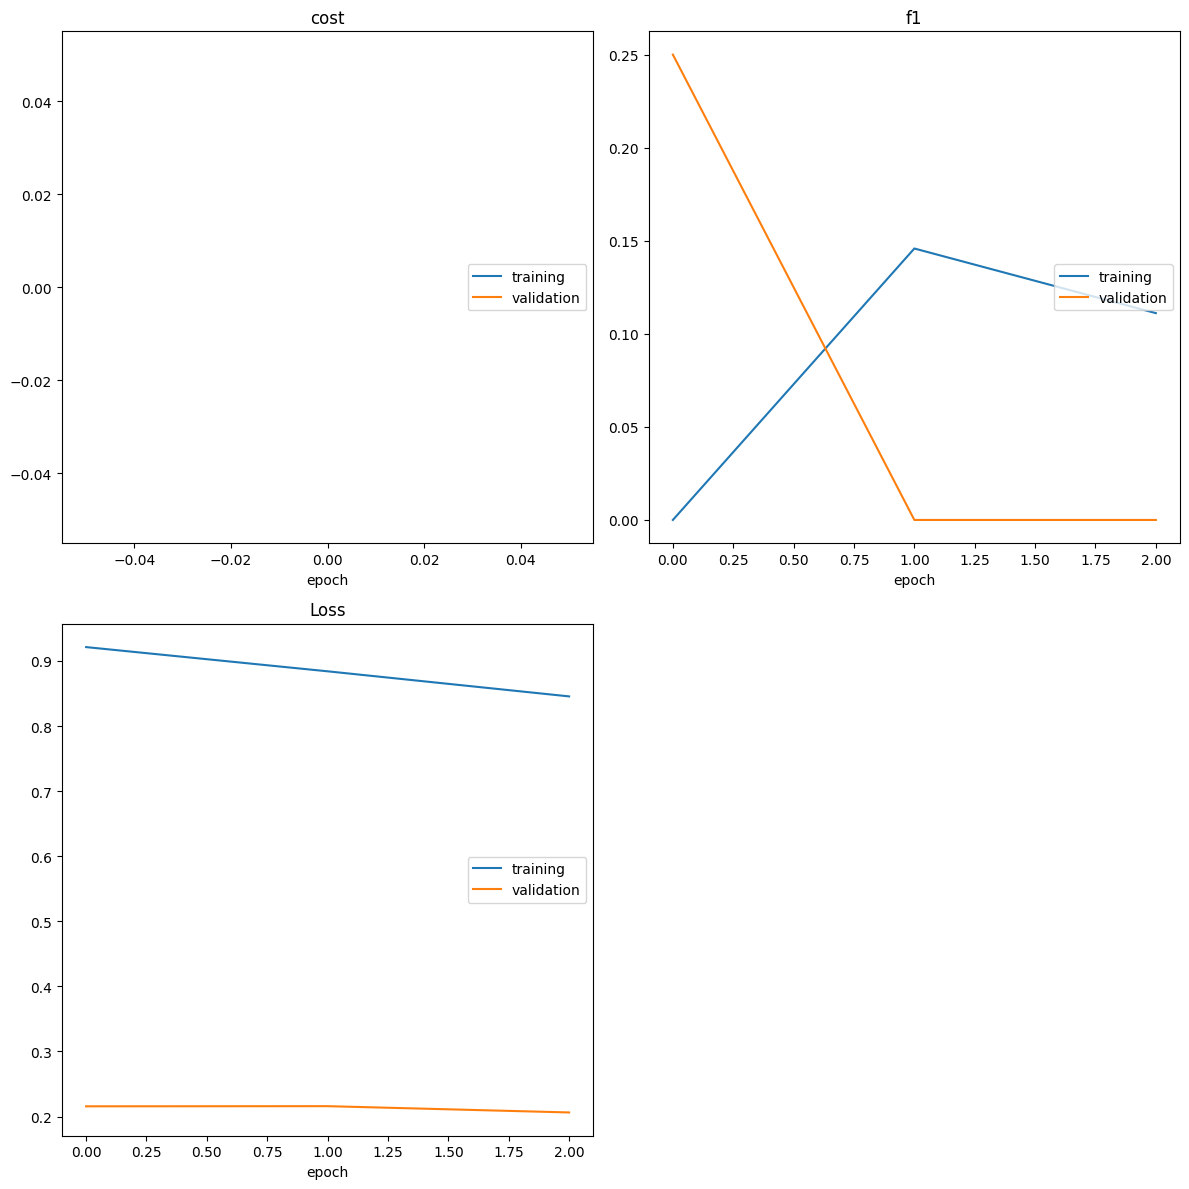

cost
	training         	 (min:      nan, max:      nan, cur:      nan)
	validation       	 (min:      nan, max:      nan, cur:      nan)
f1
	training         	 (min:    0.000, max:    0.146, cur:    0.111)
	validation       	 (min:    0.000, max:    0.250, cur:    0.000)
Loss
	training         	 (min:    0.846, max:    0.921, cur:    0.846)
	validation       	 (min:    0.206, max:    0.216, cur:    0.206)
Train Loss: 0.8455, F1: 0.1111, Cost: nan
Val Loss: 0.2063, F1: 0.0000, Cost: nan
Model saved to checkpoints/model_epoch_3.pth

Epoch 4/10


Training:   0%|          | 0/4 [00:42<?, ?it/s]


KeyboardInterrupt: 

In [7]:
from model import MultiStreamVideoClassifier

model = MultiStreamVideoClassifier(num_classes=4)
# train the model
# make a prediction on a random video
model, test_preds, test_labels, item_ids = train_model(
    model,
    train_loader,
    val_loader,
    test_loader,
    num_epochs=10,
    lr=0.001,
    weight_decay=1e-4,
    save_dir='checkpoints',
    num_classes=4
)
